Arctic sea ice forecasting using deep neural networks.

In [1]:
import numpy as np
from pathlib import Path
import sklearn
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional
import xarray as xr

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

Load and prepare data.

In [2]:
# path
path_data = Path("./data/")
start_year = 2000
end_year = 2017
# number of weeks per year
nweeks = 48
# load data
sic_xr = xr.load_dataset(path_data / "sic_erai_2000_2017.nc")
sic_xr

<xarray.Dataset>
Dimensions:    (year: 18, week: 48, latitude: 24, longitude: 56)
Coordinates:
  * year       (year) int32 2000 2001 2002 2003 2004 ... 2014 2015 2016 2017
  * week       (week) int32 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48
  * latitude   (latitude) float64 80.5 79.75 79.0 78.25 ... 64.75 64.0 63.25
  * longitude  (longitude) float64 18.0 18.75 19.5 20.25 ... 57.75 58.5 59.25
Data variables:
    sic        (year, week, latitude, longitude) float64 0.07345 ... -1.0
    mask       (latitude, longitude) int64 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1
Attributes:
    description:  Weekly Sea Ice Concentration

In [3]:
ohc_xr = xr.load_dataset(path_data /  "ohc_oras_2000_2017.nc")
ohc_xr

<xarray.Dataset>
Dimensions:    (year: 18, week: 48, latitude: 24, longitude: 56)
Coordinates:
  * year       (year) int32 2000 2001 2002 2003 2004 ... 2014 2015 2016 2017
  * week       (week) int32 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48
  * latitude   (latitude) float64 80.5 79.75 79.0 78.25 ... 64.75 64.0 63.25
  * longitude  (longitude) float64 18.0 18.75 19.5 20.25 ... 57.75 58.5 59.25
Data variables:
    ohc        (year, week, latitude, longitude) float64 108.1 108.1 ... 0.0 0.0
    mask       (latitude, longitude) int64 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1
Attributes:
    description:  Weekly ocean heat content (300m) change (Tera Joule) regrid...

In [4]:
# turn dataset into sequences
sic_seq = sic_xr.sic.values.reshape(-1, sic_xr.latitude.size, sic_xr.longitude.size)
ohc_seq = ohc_xr.ohc.values.reshape(-1, ohc_xr.latitude.size, ohc_xr.longitude.size)

# masked area from -1 to 0
sic_seq[sic_seq < 0] = 0

def normalizer(x):
    max_value = np.amax(x)
    min_value = np.amin(x)
    y = (x - min_value)/(max_value - min_value)
    return y

# normalize ohc
ohc_norm_seq = normalizer(ohc_seq)

Train/test data splitting.

In [5]:
# we deal with timeseries, the data should not be shuffled
train_years = 12

Build neural network.

In [6]:
class MetNet(nn.Module):
    def __init__(self, input_channels = 2, kernels=[2, 3, 5, 3, 1], dropout = 0.2):
        super().__init__()
        self.kernels = kernels
        # layer 1
        self.layer1 = nn.Sequential(
            nn.Conv2d(input_channels, kernels[0], kernel_size=5, stride = 1, padding = 2),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # layer 2
        self.layer2 = nn.Sequential(
            nn.Conv2d(kernels[0], kernels[1], kernel_size=5, stride = 1, padding = 2),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # layer 3
        self.layer3 = nn.Sequential(
            nn.Conv2d(kernels[1], kernels[2], kernel_size=5, stride = 1, padding = 2),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # layer 4
        self.layer4 = nn.Sequential(
            nn.Conv2d(kernels[2], kernels[3], kernel_size=5, stride = 1, padding = 2),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # layer 5
        self.layer5 = nn.Sequential(
            nn.Conv2d(kernels[3], kernels[4], kernel_size=5, stride = 1, padding = 2),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)

        return x

Set up the environment for training.

In [7]:
print ("Pytorch version {}".format(torch.__version__))
#use_cuda = torch.cuda.is_available()
#print("Is CUDA available? {}".format(use_cuda))
input_channels = 2
epochs = 100
kernels=[2, 3, 5, 3, 1]
#kernels = [2, 4, 1]
learning_rate = 0.005
dropout = 0.2

Pytorch version 1.10.0


In [8]:
# construct model
model = MetNet(input_channels, kernels, dropout)
# load whole model state
checkpoint = torch.load(Path('./models/metnet_training_checkpoint.pt'))
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

Model evaluation.

In [18]:
timestep_test = train_years * nweeks + 50
# evalutation mode
model.eval()
X_test = torch.tensor(np.stack((sic_seq[timestep_test,:,:],
                                ohc_norm_seq[timestep_test,:,:]))
                        ).float().view(-1, input_channels, 
                                        sic_xr.latitude.size,
                                        sic_xr.longitude.size)
x_var = torch.autograd.Variable(X_test, requires_grad=False)
pred = model(x_var)

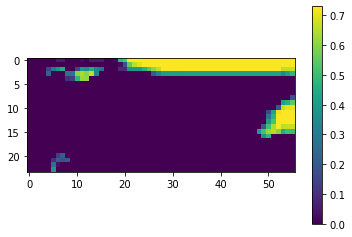

In [19]:
plt.imshow(pred[0,0,:,:].data.numpy())
plt.colorbar()

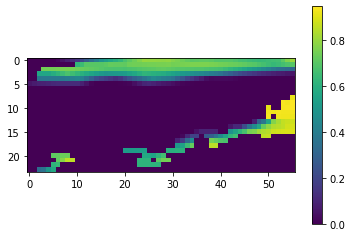

In [20]:
plt.imshow(sic_seq[timestep_test+1,:,:])
plt.colorbar()

Perform XAI.

In [32]:
# xai with captum
from captum.attr import IntegratedGradients, DeepLift, GradientShap

ig = IntegratedGradients(model)
dl = DeepLift(model)
gs = GradientShap(model)

ig_attr_test = ig.attribute(X_test, n_steps=10, target=(0, 2, 20))
# dl_attr_test = dl.attribute(X_test)
# gs_attr_test = gs.attribute(X_test, X_train)

In [33]:
results = ig_attr_test.detach().numpy()
results.shape

(1, 2, 24, 56)

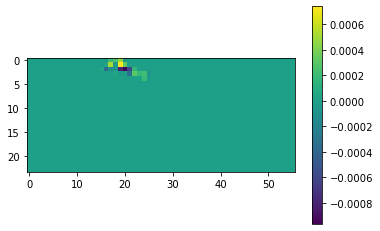

In [36]:
plt.imshow(results[0,0,:,:])
plt.colorbar()